## Библиотеки. Данные. Классы алгоритмов

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import pandas as pd
from sklearn import datasets

In [54]:
# Генерация данных для задачи классификации
X, y = datasets.make_classification(n_samples=500, n_features=10, n_informative=6, n_classes=3)

# Генерация данных для задачи регрессии
# X, y = datasets.make_regression(n_samples=250, n_features=10, n_informative=5)

In [55]:
class KNN:
    def __init__(self, k=3, scale=True):
        self.scale = scale
        self.k = k
        self.method = "classification"
        self.metric = "accuracy"
        self.score_list = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        if (y_train == y_train.astype(int)).sum() != len(y_train):
            self.method = "regression"
            self.metric = "r2"
        
    def predict(self, X_test):
        labels = [self.find_labels(x_test) for x_test in X_test]
        return np.array(labels)
    
    def find_labels(self, x_test):
        distances = [self.distance(x_test, x_train) for x_train in self.X_train]   
        k_nearest = np.argsort(distances)[:self.k]
        y_labels = [self.y_train[i] for i in k_nearest]
        
        if self.method == "regression":
            return sum(y_labels) / self.k
            
        return self.most_common(y_labels)
        
    def most_common(self, y_labels):
        a = tuple(set(y_labels))
        count = [y_labels.count(i) for i in a]
        return a[np.argsort(count)[-1]]
    
    def score(self, y_predicted, y_train):
        
        if self.method == "regression":
            return "r2", 1 - np.sum((y_predicted - y_train)**2) / np.sum((y_train.mean() - y_train)**2)
            
        return "accuracy", (y_predicted == y_train).sum() / len(y_train)

    def distance(self, x_test, x_train):
        return np.sqrt(np.abs(np.sum((x_test - x_train)**2)))
    
    def cv(self, X, y, cv=5):
        if X.shape[0] == 0:
            return self.metric, np.array([0] * cv)
        
        self.X = X
        self.y = np.reshape(y, (len(y), 1))        
        data = np.concatenate((self.X, self.y), axis=1)
        np.random.shuffle(data)
         
        data = pd.DataFrame(data)
        self.score_list = []
        
        for i in range(cv):
            lenght = int(len(y) / cv)
            
            end = i * lenght + lenght
            
            if i == cv - 1: 
                end = -1
            
            X_test = data.iloc[i * lenght: end, :-1]
            X_train = data.drop(index=X_test.index).iloc[:, :-1]
            
            if self.scale:
                for j in range(X_train.shape[1]):
                    mean = X_train.iloc[:, j].mean()
                    std = X_train.iloc[:, j].std()

                    X_train.iloc[:, j] = (X_train.iloc[:, j] - mean) / std
                    X_test.iloc[:, j] = (X_test.iloc[:, j] - mean) / std
            
            y_test = data.iloc[i * lenght: end, -1]
            y_train = data.drop(index=X_test.index).iloc[:, -1]
            
            clf = KNN()
            clf.fit(np.array(X_train), np.array(y_train))
            self.metric, s_ = clf.score(clf.predict(np.array(X_test)), np.array(y_test))
            self.score_list.append(s_)  

        return self.metric, np.array(self.score_list)

In [56]:
class RSwA:
    def __init__(self, X, y, iterations=100, 
                 manipulations=None, model=None, desired_score=None):
        self.X = X
        self.y = y
        self.iterations = iterations
        self.manipulations = manipulations
        self.desired_score = desired_score
        self.model = model
        
        self.genes     = np.ones((len(manipulations), X.shape[1]))
        self.weights   = np.ones((len(manipulations), X.shape[1]))
        self.d_weights = pd.DataFrame(columns=[str(i) for i in range(len(manipulations) * X.shape[1])])
        
        self.cv_best_score = [] # лучшее качество в поколении
        self.best_genes = None  # лучший набор ген
        self.at_iteration = 0   # ...на итерации
        self.cv_all_scores = []
        self.score = 0
        self.count = 0  
    
    def set_genes(self):        
        b = np.array([int(i) for i in self.manipulations]).reshape(len(self.manipulations), 1)  
        self.weights = self.weights * b
        a = self.weights.ravel().copy()
        shoots = int(b.sum() * self.weights.shape[1] * 0.5)

        for i in range(1, len(a), 1):
            a[i] = a[i] + a[i-1]

        for i in range(0, len(a), 1):
            a[i] = a[i] / a.max()

        indexes = set()
            
        for i in range(shoots):    
            shoot = np.random.random()

            k = 0
            while  k < len(a) and a[k] < shoot:
                k += 1

            indexes.add(k)
        
        shape = self.weights.shape
        genes = [0] * shape[0] * shape[1]

        for i in range(len(genes)):
            if i in indexes:
                genes[i] = 1

        self.genes = np.reshape(genes, shape)

    def add_feature(self):
        # формирование признаков по заданным в хромосоме манипуляциям
        X_new = []
        for i in range(self.X.shape[1]): 
            if self.genes[0, i]: X_new.append(self.X[:, i])
            if self.genes[1, i]: X_new.append(self.X[:, i]**2)
            if self.genes[2, i] and 0 not in self.X[:, i]: X_new.append(1 / self.X[:, i])
    #         if self.genes[3, i]: X_new.append(np.exp(self.X[:, i]))
            if self.genes[3, i]: X_new.append(np.sin(self.X[:, i]))

        X_new = np.array(X_new).T
        return X_new

    def fitness_func(self):  
        # расчет качества модели по скользящему контролю
        X_new = self.add_feature()
        cv_score = self.model.cv(X_new, self.y, cv=5)[1]
        cv_score = cv_score.sum() / len(cv_score)
        
        self.count += 1
        self.cv_all_scores.append(cv_score)

        if cv_score > self.score:
            self.score = cv_score
            self.best_genes = self.genes
            self.at_iteration = self.count

        return (cv_score)

    def change_weights(self, adapt):
        a = self.weights.ravel().copy()
        g = self.genes.ravel().copy()

        for i in range(len(a)):
            if g[i]:
                a[i] = a[i] * adapt
        
        self.weights = np.reshape(a, self.weights.shape)
        
        temporary = pd.DataFrame([a], columns=self.d_weights.columns)
        self.d_weights = self.d_weights.append(temporary, ignore_index=True)
        
    def go_search(self):
        
        for index, i in enumerate(self.manipulations):
            if i and self.weights[index, :].sum() == 0.0:
                self.weights[index, :] = 1
        
        self.set_genes()
        self.add_feature()
        self.fitness_func()
        
        if len(self.cv_all_scores) == 1:
            return
        
        if self.cv_all_scores[-1] > self.cv_all_scores[-2] * 1.01:
            self.change_weights(1.1)    
        elif self.cv_all_scores[-1] < self.cv_all_scores[-2] * 0.99:
            self.change_weights(0.9) 

In [57]:
def plot_importance(cmap):
    plt.figure(figsize=(5, 2))
    plt.pcolormesh(rs.weights, cmap=cmap)
    plt.xticks(np.arange(rs.weights.shape[1]) + 0.5, ["x" + str(i) for i in range(rs.weights.shape[1])])
    plt.yticks(np.arange(rs.weights.shape[0]) + 0.5, manipulations)
    plt.xlabel("features")
    plt.ylabel("manipulations")
    plt.title("Features weights")
    
    for i in range(rs.weights.shape[1]):
        for j in range(rs.weights.shape[0]):
            plt.text(i + 0.5, j + 0.5, round(rs.weights[j , i], 2), 
                     ha='center', va='center', color="orange")

    plt.show()

In [58]:
def plot_results(vmin=0, vmax=1, initial_score=0):
    print("Best manipulations:\n", rs.best_genes,
      "\n\nwith score: ", rs.score, " at iteration # ", rs.at_iteration)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3)) 

    axes[0].plot(np.log(rs.d_weights), label="weights",)
    axes[0].set_ylabel('log(weights)')
    axes[0].set_xlabel('iterations')    
    
    axes[1].plot(rs.cv_all_scores, label="all cv score")
    axes[1].set_ylabel('cv score')
    axes[1].plot([0, len(rs.cv_all_scores) - 1], [1, 1], c="k")
    axes[1].plot([0, len(rs.cv_all_scores) - 1], [initial_score, initial_score], c="r", label="initial cv score")
    axes[1].set_xlabel('iterations')
    axes[1].set_ylim(vmin, vmax)
#     axes[0].set_ylim(vmin, vmax)
    plt.legend(loc='lower right')
    plt.show()

## Поиск информативных признаков и манипуляций над признаками

### Инициализация модели KNN

In [60]:
# Качество по кросс валидации на неизмененных данных
model = KNN(k=3, scale=True)
initial_score = model.cv(X, y, cv=5)[1].sum() / 5
initial_score

0.7334545454545454

### Поиск информативных признаков

In [39]:
manipulations = ["x", "x2", "1/x", "sin(x)"] # допустимые манипуляции над признаками

In [61]:
rs = RSwA(X, y,                 # передаем признаки и целевую переменную
          iterations=250,      # число итераций
          manipulations="1000", # какие манипуляции над признаками пробовать
          model=model,          # модель
          desired_score=None)   # желаемое качество

for i in tqdm.tqdm(range(rs.iterations)):
    rs.go_search()
    
    if rs.desired_score is not None and rs.desired_score >= rs.score:
        break
    
print("*** DONE ***")

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [38:01<00:00,  9.12s/it]

*** DONE ***


Best manipulations:
 [[0 1 0 1 0 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]] 

with score:  0.7594343434343435  at iteration #  248


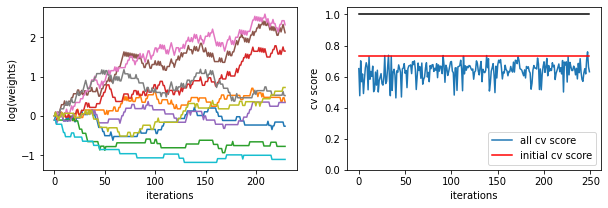

In [62]:
plot_results(vmin=0.0, vmax=1.05, initial_score=initial_score)

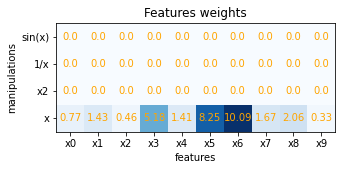

In [63]:
plot_importance(cmap='Blues')

### Поиск информативных манипуляций над признаками

In [64]:
rs = RSwA(X, y,                 # передаем признаки и целевую переменную
          iterations=250,      # число итераций
          manipulations="1111", # какие манипуляции над признаками пробовать
          model=model,          # модель
          desired_score=None)   # желаемое качество

for i in tqdm.tqdm(range(rs.iterations)):
    rs.go_search()
    
    if rs.desired_score is not None and rs.desired_score >= rs.score:
        break
    
print("*** DONE ***")

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [37:13<00:00,  8.93s/it]

*** DONE ***


Best manipulations:
 [[1 1 0 1 0 1 1 1 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 1 1 0]] 

with score:  0.7794747474747475  at iteration #  227


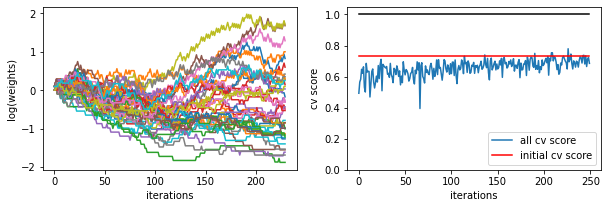

In [65]:
plot_results(vmin=0.0, vmax=1.05, initial_score=initial_score)

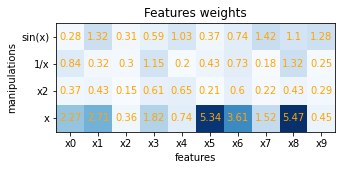

In [66]:
plot_importance(cmap='Blues')